In [1]:
import warnings
warnings.filterwarnings('ignore')

First we are going to try w2v with no stemming, then with stemmed data

In [2]:
import pickle

In [3]:
with open('../data/clean-data-nostem.pkl', 'rb') as fp:
    X,Y = pickle.load(fp)
fp.close()

In [4]:
with open('../data/saved-res.pkl','rb') as fp:
    saved_res = pickle.load(fp)
fp.close()

### Tokenizing

In [5]:
X = [i.split() for i in X]

### W2V without stemming

In [6]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(X,size=500,workers=4,min_count=1)

### Creating sentence vector

In [7]:
import numpy as np
sen_vector = np.empty((len(X),500)); index = 0
for i in X:
    vector = np.zeros(500)
    for word in i:
        vector += model[word]
    vector = vector/len(i)
    sen_vector[index] = vector
    index += 1

In [8]:
pred = {}
l = int(0.8*len(X))

In [9]:
from sklearn.linear_model import LogisticRegression

### Logistic regression (L1)

In [10]:
lr = LogisticRegression(penalty='l1',C=1,n_jobs=-1,class_weight='balanced')
lr.fit(sen_vector[:l],Y[:l])
pred['Logistic L1'] = lr.predict(sen_vector[l:])

In [11]:
saved_res['LR L1 with self trained W2V no stem'] = pred['Logistic L1']

### Logistic regression (L2)

In [12]:
lr = LogisticRegression(penalty='l2',C=1,n_jobs=-1,class_weight='balanced')
lr.fit(sen_vector[:l],Y[:l])
pred['Logistic L2'] = lr.predict(sen_vector[l:])

In [13]:
saved_res['LR L2 with self trained W2V no stem'] = pred['Logistic L2']

### Plotting ROC curve

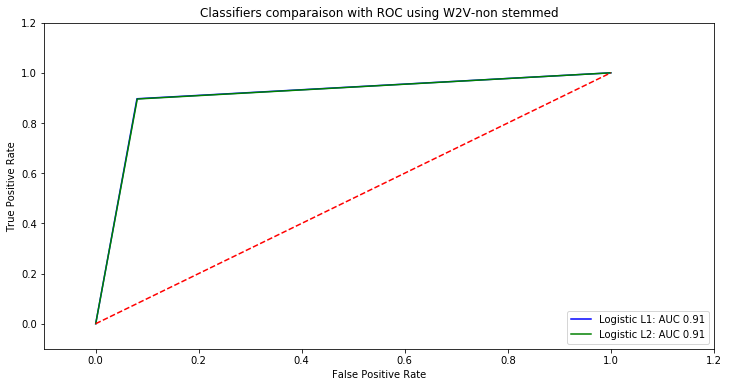

In [14]:

import numpy as np
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))

def formatt(x):
    return x;

vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']

for model, predicted in pred.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y[l:], vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC using W2V-non stemmed')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Observation without class weights:
* The AUC doesn't change no matter the value of C.
* Simple BOW and tfid gave better results than self trained W2V.
* W2V with vector size as 100 gives AUC as 0.81.
* W2V with vector size as 200 gives AUC as 0.84.
* W2v with vector size as 500 gives AUC as 0.86.

### Observation with class weights:
* With balanced class weights and vector size as 500 we get an AUC of 0.91.

Now i would train W2V using stemmed data. My hyoothesis is the result won't vary much furthur

In [15]:
import pickle
with open('../data/clean-data.pkl','rb') as fp:
    X,Y = pickle.load(fp)

### Tokenizing:

In [16]:
X = [i.split() for i in X]

### W2V with stemming

In [17]:
model = Word2Vec(X,size=500,workers=4,min_count=1)

### Creating sentence vector

In [18]:
import numpy as np
sen_vector = np.empty((len(X),500)); index = 0
for i in X:
    vector = np.zeros(500)
    for word in i:
        vector += model[word]
    vector = vector/len(i)
    sen_vector[index] = vector
    index += 1

In [19]:
pred = {}
l = int(0.8*len(X))

In [20]:
from sklearn.linear_model import LogisticRegression

### Logistic regression (L1)

In [21]:
lr = LogisticRegression(penalty='l1',C=1,n_jobs=-1,class_weight='balanced')
lr.fit(sen_vector[:l],Y[:l])
pred['Logistic L1'] = lr.predict(sen_vector[l:])

In [22]:
saved_res['LR L1 with self trained W2V stem'] = pred['Logistic L1']

### Logistic regression (L2)

In [23]:
lr = LogisticRegression(penalty='l2',C=1,n_jobs=-1,class_weight='balanced')
lr.fit(sen_vector[:l],Y[:l])
pred['Logistic L2'] = lr.predict(sen_vector[l:])

In [24]:
saved_res['LR L2 with self trained W2V stem'] = pred['Logistic L2']

### Plotting ROC curve

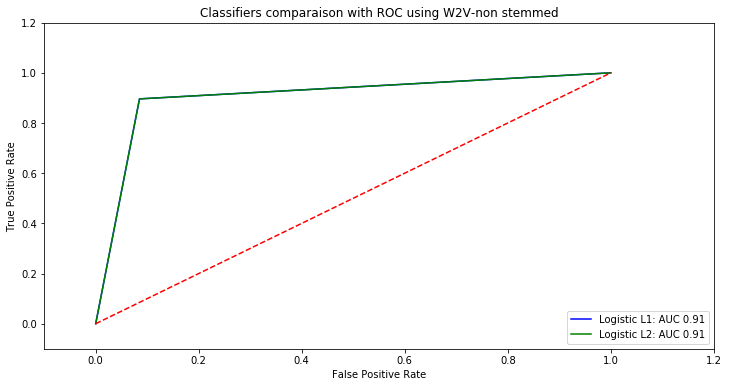

In [25]:
import numpy as np
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))

def formatt(x):
    return x;

vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']

for model, predicted in pred.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y[l:], vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC using W2V-non stemmed')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Observation:
* Stemming decreases the performance (observed without class weights).
* With class weights: The AUC was 0.91 for L1 and 0.90 for L2 regularizer(the vector size for this observation was again 500)

In [27]:
# Saving for later analysis
with open('../data/saved-res.pkl','wb') as fp:
    pickle.dump(saved_res,fp)
fp.close()